In [1]:
%load_ext autoreload
%autoreload 2

# **Сделать полный отчёт до 15 июня**

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit
import seaborn as sns
import awkward as ak

from progressbar import progressbar
import re

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
season = '19'
total_info_filename = f'../data/{season}/total_info.txt'
total_info = pd.read_csv(total_info_filename, index_col=0)

In [4]:
final_states = ['$\pi^+\pi^-\pi^0$', '$2\pi^+2\pi^-$', '$\pi^+\pi^-2\pi^0$', '$2\pi^+2\pi^-\pi^0$', '$2\pi^+2\pi^-2\pi^0$', '$3\pi^+3\pi^-$',
               '$K^+K^-$', '$K_SK_L$', '$K^+K^-\pi^0$', '$K_SK^+\pi^-$', '$K_LK^-\pi^+$', '$K^+K^-\pi^+\pi^-$', '$K^+K^-\pi^0\pi^0$', '$K_LK_S\pi^+\pi^-$', 
               '$K^+K_S\pi^-\pi^0$', '$K^-K^0\pi^+\pi^0$', '$K_LK_S\pi^0\pi^0$', '$\pi^+\pi^-$', '$p\bar{p}$', '$n\bar{n}$', '$\pi^+\pi^-\eta$', 
               '$K_SK^-\pi^+$', '$K_LK^+\pi-$', '$\pi^+\pi^-3\pi^0$', '$\pi^+\pi^-4\pi^0$', '$K_SK_S\pi^+\pi^-$', '$\pi^0\gamma$', '$\eta\gamma$', 
               'wtf']

# Подготовить `csv` файлы

In [5]:
def ctr(df, c=0, ptot_cut=40):
    df = df.query(f'(abs(trho_n)>{c})&(abs(trho_p)>{c})&(tptot_p>{ptot_cut})&(tptot_n>{ptot_cut})&(ksdpsi<3)&(abs(tz_p)<12)&(abs(tz_n)<12)')
    return df

In [6]:
exp_files = total_info['exp_tree']

In [8]:
for i, row in total_info.iterrows():
    file = row['exp_tree'].strip()
    tr = uproot.open(file)['tr_ph']
    h = preprocess.Handler(tr, cut_z=12)
    df = ctr(h.get_good_kaons(photons=None))
    filename = f"../csv/19/{re.findall(r'(tr.+).root', file)[0]}.csv"
    df.to_csv(filename)
    total_info.at[i, 'exp_csv'] = filename[3:]
    total_info.to_csv(total_info_filename)

# Fits

In [5]:
def open_trees(row):
    df = {}
    path = {
        'exp' : row['exp_tree'] if ('exp_csv' not in row) or (row['exp_csv']==np.nan) else row['exp_csv'],
        'mc_kskl' : row['mc_tree_kskl_mcgpj'],
    }
    if ('mlt_raw' in row) and not(np.isnan(row['mlt_raw'])):
        path['mlt_raw'] = f'/store17/petrov/data/kskl20/tr_ph/multi/19/tr_ph_run0{int(row["mlt_raw"])}.root'
    if ('ksklpi0_raw' in row) and not(np.isnan(row['ksklpi0_raw'])):
        path['ksklpi0_raw'] = f'/store17/petrov/data/kskl20/tr_ph/kkp0/tr_ph_run0{int(row["ksklpi0_raw"])}.root'
    tr = {i : uproot.open(path[i])['tr_ph'] if (path[i][-4:]=='root') else path[i] for i in path}
    for t in tr:
        if isinstance(tr[t], str):
            df[t] = pd.read_csv('../' + tr[t])
        else:
            h = preprocess.Handler(tr[t], cut_z=12)
            df[t] = h.get_good_kaons(photons=None)
    if 'mlt_raw' in df:
        df['mlt_raw'] = df['mlt_raw'].query('finalstate_id!=8') #drop kskl from multihadrons
    return df

In [6]:
def get_exp_lum(df):
    """
    Получить светимость и ошибку, `df` - экспериментальные данные
    """
    dd = df.groupby('runnum').agg({'ebeam': 'first', 'lumoff': 'first', 'lumofferr': 'first'})
    dd['lumerrsq'] = dd['lumofferr']**2
    return {'lum': dd['lumoff'].sum(), 'lum_err': np.sqrt(dd['lumerrsq'].sum())}

def results_to_series(row, fit_exp, fit_mc, lum_dict, fit_range):
    """
    Преобразовать результат в строку
    """
    result = {}
    result['n_sig'] = fit_exp.m.values['n_sig']
    result['n_bkg'] = fit_exp.m.values['n_bkg']
    result['n_mc'] = fit_mc.m.values['n_sig']
    result['n_sig_err'] = fit_exp.m.errors['n_sig']
    result['n_bkg_err'] = fit_exp.m.errors['n_bkg']
    result['n_mc_err'] = fit_mc.m.errors['n_sig']
    result['x1_min'], result['x1_max'] = fit_range
    result['lum'], result['lum_err'] = lum_dict['lum'], lum_dict['lum_err']
    return pd.Series(result, name=row['elabel'])

In [7]:
it = total_info.iterrows()

In [8]:
df_fit_results = pd.read_csv(f'../data/{season}/results/new_method/signal.csv', index_col=0) \
    if os.path.isfile(f'../data/{season}/results/new_method/signal.csv') else pd.DataFrame()

In [9]:
df_fit_results.head()

,n_bkg,n_bkg_err,n_mc,n_mc_err,n_sig,n_sig_err,x1_max,x1_min
537.5_70914,1342.208243,45.990684,2953.964272,54.350395,2837.819866,60.088751,20.0,-70.0
550_70260,1242.428162,48.502213,2717.124011,52.132430,2061.582191,57.280145,25.0,-50.0
575_71544,1177.905893,42.836667,2465.058712,49.638786,746.168840,37.465375,30.0,-50.0


In [725]:
idx, row = next(it)
row

elabel                                                          955_81775
emeas                                                          956.046875
exp_tree                root://sl10cmd//scan2019/scan2019_tr_ph_fc_e95...
mc_raw_kskl_mcgpj       /store17/petrov/data/kskl20/raw/19/kskl_955_81...
mc_tree_kskl_mcgpj      /store17/petrov/data/kskl20/tr_ph/19/tr_ph_ksk...
mc_tree_kskl_uniform    /store17/petrov/data/kskl_uniform_individual/1...
mlt_raw                                                           53325.0
ksklpi0_raw                                                       45802.0
exp_csv                                       csv/19/tr_ph_fc_e955_v8.csv
Name: 39, dtype: object

In [727]:
df = open_trees(row)

In [ ]:
df.keys()

In [ ]:
pys.hep_histo(df['exp'].x1, range=(-100, 100), bins=100);
pys.my_style(f'Exp, {df["exp"].ebeam.mean():.2f} MeV', 'x1', 'num of events per bin');

In [707]:
fit_range = (-50, 20)
fit2poly = pyfit.FitPoly2(fit_range)

In [708]:
f = pyfit.Fitter(df['mlt_raw'].x1, fit2poly, dict(n_sig=0, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=580, b=1, c=0),
            fit_range=fit_range, lims=dict(n_sig=(0,0), m=(0, 0), sL=(1,1), sR=(1, 1), 
            aL=(1,1), aR=(1,1), n_bkg=(0, None), b=(None, None), c=(None, None)) )
f.fit()

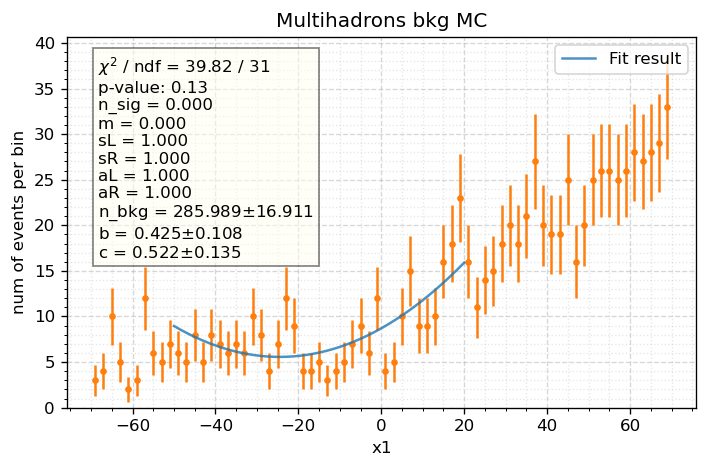

In [709]:
f.plot((-70, 70), bins=70, title='Multihadrons bkg MC', xtitle='x1', ytitle='num of events per bin');

In [710]:
fit2poly = pyfit.FitPoly2(fit_range)

In [713]:
fmc = pyfit.Fitter(df['mc_kskl'].x1, fit2poly, dict(n_sig=100, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=0, b=0, c=0),
            fit_range=fit_range, lims=f.get_limits(n_sigmas=0, include=['b', 'c'], 
            my_lims=dict(n_sig=(0, None), m=(-20, 20), sL=(0.1, None), sR=(0.1, None), aL=(0, None), aR=(0, None), n_bkg=(0, 0))) )
fmc.fit()

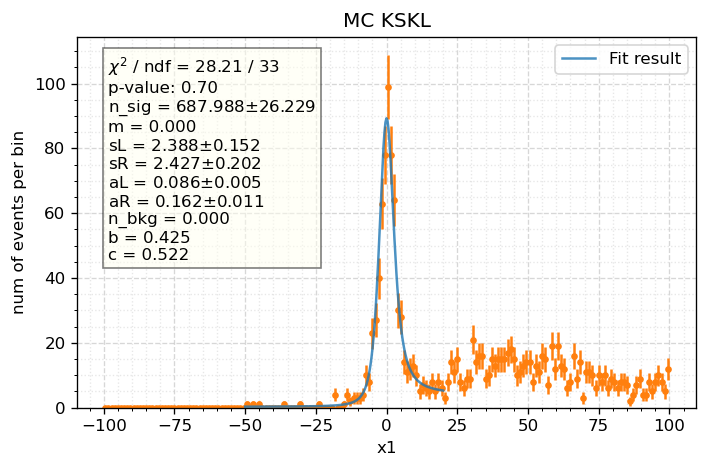

In [714]:
hist_rng, bins = (-100, 100), 180
fmc.plot(hist_rng, bins=bins, title='MC KSKL', xtitle='x1', ytitle='num of events per bin');

осознать форму сигнала - поближе к $\phi$ мезону

In [715]:
lims_mc = fmc.get_limits(n_sigmas=3, include=['sR', 'sL', 'aL', 'aR', 'm'])
lims_mc['n_bkg'] = (0, None)

In [716]:
pars_mc = fmc.get_params()
pars_mc['n_bkg'] = 100

In [717]:
f2 = pyfit.Fitter(df['exp'].x1, fit2poly, pars_mc,#dict(n_sig=100, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=100, b=1, c=0),
            fit_range=fit_range, lims=lims_mc, sigmas=fmc.get_sigmas(exclude=['n_sig', 'n_bkg',  'b', 'c', 'm']) )
f2.fit()

In [718]:
w0 = f2.m.values['n_sig']/len(df['mc_kskl'].query(f'x1>{fit_range[0]}&x1<{fit_range[1]}').x1)
processes = list(df['mlt_raw'].finalstate_id.value_counts().sort_values(ascending=True).index)

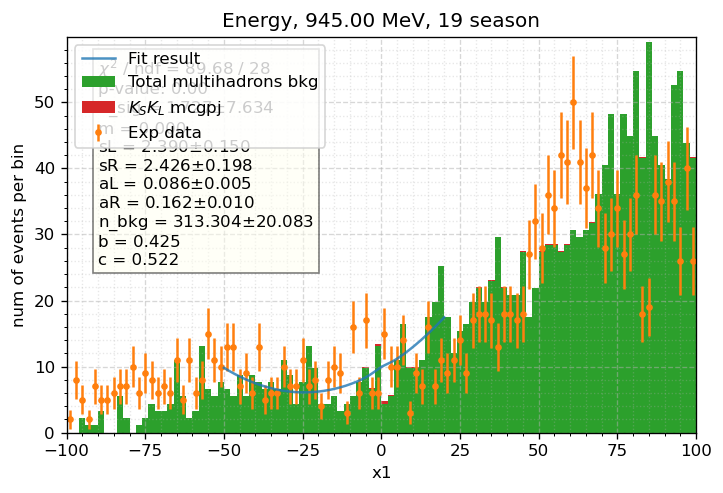

In [719]:
hist_rng, bins = (-100, 100), 100
f2.plot(hist_rng, bins=bins, xtitle='x1', ytitle='num of events per bin', label='Exp data')
bkg_dat = df['mlt_raw'].x1
bkg_dat_kskl = df['mc_kskl'].x1

d1 = plt.hist(bkg_dat, range=hist_rng, bins=bins, label='Total multihadrons bkg',
         weights=np.ones_like(bkg_dat)*(f2.m.values['n_bkg']/len(bkg_dat.loc[(bkg_dat<f2.fit_range[1])&(bkg_dat>f2.fit_range[0])])))
plt.hist(df['mc_kskl'].x1, bins=bins, range=hist_rng, bottom=d1[0], label='$K_SK_L$ mcgpj', 
         weights=np.ones_like(df['mc_kskl'].x1)*w0)
plt.title(f'Energy, {df["exp"].ebeam.mean():.2f} MeV, 19 season')
plt.legend();
plt.xlim(hist_rng);

In [720]:
lum_dict = get_exp_lum(df['exp'])
result_row = results_to_series(row, f2, fmc, lum_dict, fit_range)
if len(df_fit_results.index.intersection([result_row.name]))>0:
    df_fit_results = df_fit_results.drop([result_row.name])
df_fit_results = df_fit_results.append(result_row)
df_fit_results

,n_bkg,n_bkg_err,n_mc,n_mc_err,n_sig,n_sig_err,x1_max,x1_min,lum,lum_err
537.5_70914,1342.208243,45.990684,2953.964272,54.350395,2.837820e+03,60.088751,20.0,-70.0,1229.268367,1.828896
550_70260,1597.431426,48.830764,2642.077830,51.630741,2.010500e+03,52.892694,20.0,-70.0,1434.314148,2.020221
575_71544,1177.905893,42.836667,2465.058712,49.638786,7.461688e+02,37.465375,30.0,-50.0,1058.449522,1.811253
587.5_71908,1437.507185,45.597938,2312.886601,48.093400,5.223938e+02,34.121675,30.0,-50.0,1169.377513,1.944858
600_72268,1388.929789,44.583586,2122.917021,46.075606,4.071876e+02,31.711732,30.0,-50.0,1165.508851,1.981560
612.5_72545,1388.978100,45.378988,2073.028425,47.257051,3.492478e+02,31.184005,30.0,-50.0,1177.838452,2.034182
625_72787,1254.202571,42.383833,1941.956104,44.701596,2.817124e+02,28.709853,30.0,-50.0,1093.271575,1.997800
637.5_73035,1483.433875,44.028611,1937.857624,44.020736,1.745397e+02,25.087055,50.0,-50.0,1021.923961,1.970024
641_82925,8455.179241,110.318410,1903.118131,43.634492,1.149561e+03,68.090694,50.0,-50.0,6272.352874,4.909128
650_73374,1299.537235,41.459620,1819.013168,42.718861,1.274652e+02,23.399302,50.0,-50.0,953.083673,1.941545


In [702]:
# df_fit_results.to_csv(f'../data/{season}/results/new_method/signal.csv')

____

In [761]:
d0 = pd.read_csv('../data/19/results/signal.csv', index_col=0)
# (d0['n_sig_exp']/d0['n_sig_mc']).head(8)
d0['r'] = d0['n_sig_exp']/d0['n_sig_mc']
d0['r_err'] = d0['r']*np.sqrt( (d0['n_sig_exp_err']/d0['n_sig_exp'])**2 + (d0['n_sig_mc_err']/d0['n_sig_mc'])**2 )

In [756]:
d1 = total_info[['elabel', 'emeas']].set_index('elabel').dropna().join(df_fit_results).dropna()
d1 = d1.reset_index().set_index('emeas')
d1['r'] = d1['n_sig']/d1['n_mc']
d1['r_err'] = d1['r']*np.sqrt( (d1['n_sig_err']/d1['n_sig'])**2 + (d1['n_mc_err']/d1['n_mc'])**2 )

<ErrorbarContainer object of 3 artists>

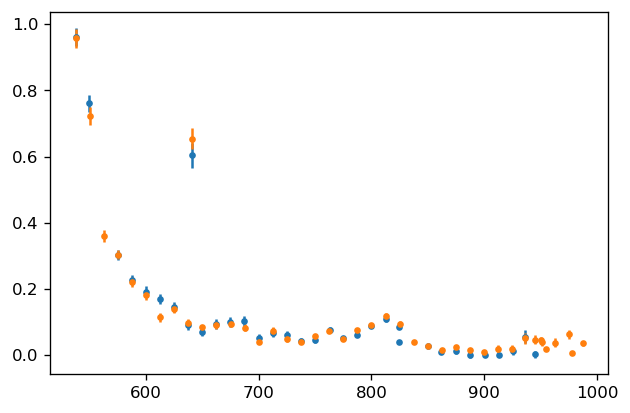

In [763]:
plt.errorbar(d1.index, d1['r'], yerr=d1['r_err'], fmt='.')
plt.errorbar(d0.index, d0['r'], yerr=d0['r_err'], fmt='.')

In [739]:
(df_fit_results['n_sig']/df_fit_results['n_mc']).head(7)

537.5_70914    0.960682
550_70260      0.760954
575_71544      0.302698
587.5_71908    0.225862
600_72268      0.191806
612.5_72545    0.168472
625_72787      0.145066
dtype: float64

In [167]:
def norm_in_rng(df1, df2, rng):
    return len(df2[(df2<rng[1])&(df2>rng[0])])/len(df1[(df1<rng[1])&(df1>rng[0])])

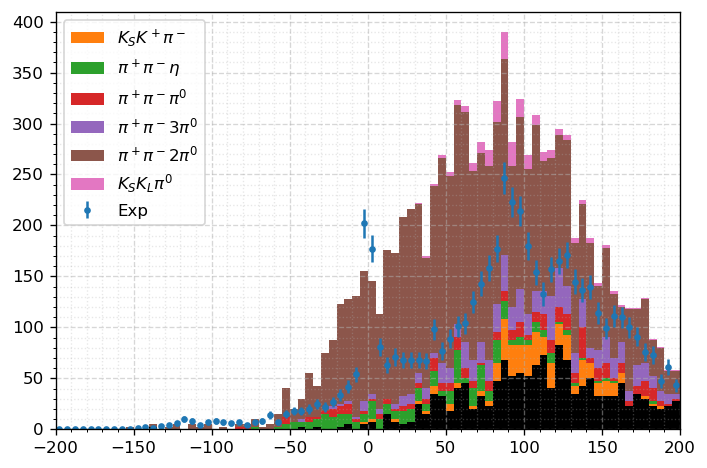

In [169]:
processes = list(df['mlt'].query('finalstate_id!=8').finalstate_id.value_counts().sort_values(ascending=True).index)
bins, rng = 80, (-200, 200)
dat_bottom = None
pys.hep_histo(ctr(df['exp']).x1, bins=bins, range=rng, label='Exp')
w0 = norm_in_rng(df['mlt'].query('finalstate_id!=8').x1, ctr(df['exp']).x1, (-120, -40))
for i, process in enumerate(processes):
    de = ctr(df['mlt'].query(f'finalstate_id=={process}')).x1
    label = final_states[process-1] if i>=(len(processes)-5) else None
    weights = w0*np.ones_like(de) #None
    dat = plt.hist(de, bins=bins, range=rng, bottom=dat_bottom, label=label, weights=weights, color=None if i>=(len(processes)-5) else 'black')
    dat_bottom = dat_bottom + dat[0] if dat_bottom is not None else dat[0]
    
add_processes = {
#     'kkpp' : ['$K_SK_S\pi^+\pi^-$', 1],
    'kkp' : ['$K_SK_L\pi^0$', (2.3/1)*(2/10)*657/len(ctr(df['mc']).x1)/7],#0.05*28/35],
#     'kskleta' : ['$K_SK_L\eta$', 0.01],
                }
for pro in add_processes:
    if pro in df:
        dpro = ctr(df[pro]).x1
        dat = plt.hist(dpro, bins=bins, range=rng, bottom=dat_bottom, label=add_processes[pro][0], weights=np.ones_like(dpro)*add_processes[pro][1])
        dat_bottom += dat[0]
# plt.hist(ctr(df['mc']).x1, bins=bins, range=rng, bottom=dat_bottom, label='$K_SK_L$', 
#          weights=np.ones_like(ctr(df['mc']).x1)*w0*len(df['mlt'].query('finalstate_id==8'))/len(ctr(df['mc']).x1))
pys.my_style(legend=True, xlim=rng);

посмотреть инв массу всех пар фотонов после отборов

посмотреть на энергию самого жёсткого фотона (KL кластер vs pi0)

построить массу отдачи

построить угол между импульсом KL и ближайшим кластером (и ещё и зависимость от энергии)

если стат ошибка большая, то отбор можно оставить

можно сделать отбор по инв. массе отдачи (<0 или ещё жёстче), но перед этим проверить, не являются ли эти события KS с align 0

In [286]:
fit_range = (-60, 30)
fit2poly = pyfit.FitPoly2(fit_range)

In [287]:
f = pyfit.Fitter(ctr(df['mlt']).query('finalstate_id!=8').x1, fit2poly, dict(n_sig=0, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=580, b=1, c=0),
            fit_range=fit_range, lims=dict(n_sig=(0,0), m=(0, 0), sL=(1,1), sR=(1, 1), 
                                           aL=(1,1), aR=(1,1), n_bkg=(0, None), b=(None, None), c=(None, None)) )

In [288]:
f.fit()

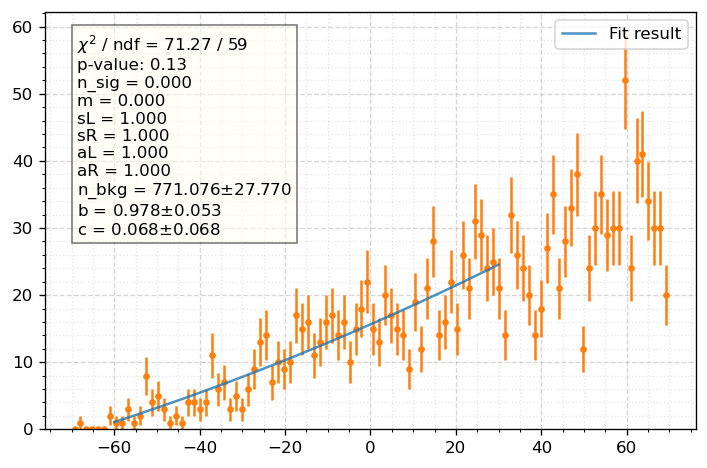

In [291]:
f.plot((-70, 70), bins=100)

In [292]:
fit2poly = pyfit.FitPoly2(fit_range)

In [293]:
fmc = pyfit.Fitter(ctr(df['mc']).x1, fit2poly, dict(n_sig=100, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=0, b=0, c=0),
            fit_range=fit_range, lims=f.get_limits(n_sigmas=0, include=['b', 'c'], 
            my_lims=dict(n_sig=(0, None), m=(-20, 20), sL=(0.1, None), sR=(0.1, None), aL=(0, None), aR=(0, None))) )
fmc.fit()

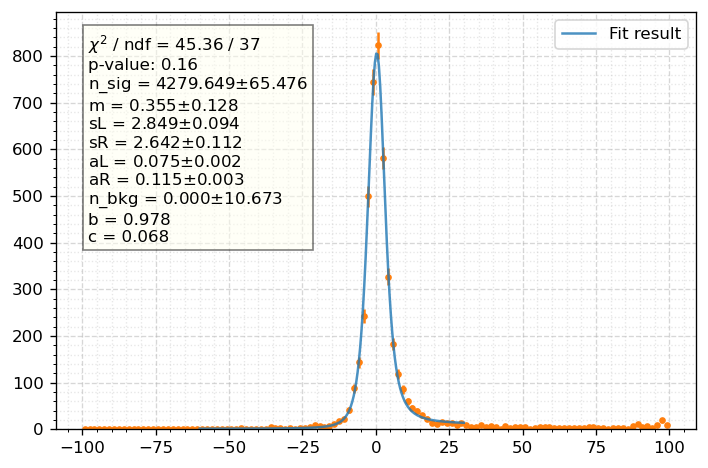

In [295]:
hist_rng, bins = (-100, 100), 120
fmc.plot(hist_rng, bins=bins)

In [296]:
lims_mc = fmc.get_limits(n_sigmas=133, include=['sR', 'sL', 'aL', 'aR'])

In [297]:
pars_mc = fmc.get_params()
pars_mc['n_bkg'] = 100

In [298]:
lims_mc

{'aR': (0, 0.5337743715312704),
 'm': (-20, 20),
 'aL': (0, 0.35471272589745484),
 'n_bkg': (0, None),
 'sR': (0.1, 17.48573347855701),
 'n_sig': (0, None),
 'c': (0.06802656382128855, 0.06802656382128855),
 'sL': (0.1, 15.394684898519465),
 'b': (0.9777698370094529, 0.9777698370094529)}

In [299]:
f2 = pyfit.Fitter(ctr(df['exp']).x1, fit2poly, pars_mc,#dict(n_sig=100, m=0, sL=1, sR=1, aL=1, aR=1, n_bkg=100, b=1, c=0),
            fit_range=fit_range, lims=lims_mc, sigmas=fmc.get_sigmas(exclude=['n_sig', 'n_bkg',  'b', 'c', 'm']) )

In [300]:
f2.fit()

In [301]:
f2.m.values['n_bkg']

644.2161871859655

In [302]:
# w0 = norm_in_rng(df['mlt'].query('finalstate_id!=8').x1, ctr(df['exp']).x1, (-120, -40))
w0 = f2.m.values['n_sig']/len(ctr(df['mc'].query(f'x1>{fit_range[0]}&x1<{fit_range[1]}')).x1)#(f2.m.values['n_sig'] + f2.m.values['n_bkg'])

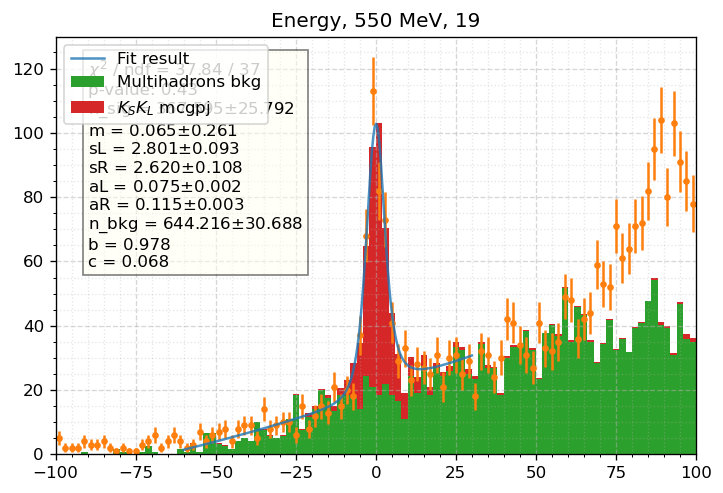

In [303]:
hist_rng, bins = (-100, 100), 100
f2.plot(hist_rng, bins=bins)
bkg_dat = df['mlt'].query('(finalstate_id!=8)').x1
bkg_dat_kskl = df['mc'].x1
d1, h1 = np.histogram(bkg_dat, range=hist_rng, bins=bins, 
                     weights=np.ones_like(bkg_dat)*(f2.m.values['n_bkg']/len(bkg_dat.loc[(bkg_dat<f2.fit_range[1])&(bkg_dat>f2.fit_range[0])])))
plt.hist(bkg_dat, range=hist_rng, bins=bins, label='Multihadrons bkg',
         weights=np.ones_like(bkg_dat)*(f2.m.values['n_bkg']/len(bkg_dat.loc[(bkg_dat<f2.fit_range[1])&(bkg_dat>f2.fit_range[0])])))
kskl_cmd2 = ctr(df['mlt'].query('finalstate_id==8'))
# plt.hist(kskl_cmd2.x1, bins=bins, range=hist_rng, bottom=d1, label='$K_SK_L$ cmd2gen', 
#          weights=np.ones_like(kskl_cmd2.x1)*f2.m.values['n_sig']/len(kskl_cmd2.query(f'x1>{fit_range[0]}&x1<{fit_range[1]}').x1), alpha=0.5,
#         )
plt.hist(ctr(df['mc']).x1, bins=bins, range=hist_rng, bottom=d1, label='$K_SK_L$ mcgpj', 
         weights=np.ones_like(ctr(df['mc']).x1)*w0)
plt.title('Energy, 550 MeV, 19')
plt.legend();
plt.xlim(hist_rng);

In [55]:
# processes = list(df['mlt'].query('finalstate_id!=8').finalstate_id.value_counts().sort_values(ascending=True).index)
# bins, rng = 120, (-200, 200)
# dat_bottom = None
# pys.hep_histo(ctr(df['exp']).x1, bins=bins, range=rng, label='Exp')
# w0 = 1679/1818
# for i, process in enumerate(processes):
#     de = ctr(df['mlt'].query(f'finalstate_id=={process}')).x1
#     label = final_states[process-1] if i>=(len(processes)-5) else None
#     weights = w0*np.ones_like(de) #None
#     dat = plt.hist(de, bins=bins, range=rng, bottom=dat_bottom, label=label, weights=weights, color=None if i>=(len(processes)-5) else 'black')
#     dat_bottom = dat_bottom + dat[0] if dat_bottom is not None else dat[0]
    
# add_processes = {
# #     'kkpp' : ['$K_SK_S\pi^+\pi^-$', 1],
# #     'kkp' : ['$K_SK_L\pi^0$', (2.3/1)*(2/10)*657/len(ctr(df['mc']).x1)],#0.05*28/35],
# #     'kskleta' : ['$K_SK_L\eta$', 0.01],
#                 }
# for pro in add_processes:
#     if pro in df:
#         dpro = ctr(df[pro]).x1
#         dat = plt.hist(dpro, bins=bins, range=rng, bottom=dat_bottom, label=add_processes[pro][0], weights=np.ones_like(dpro)*add_processes[pro][1])
#         dat_bottom += dat[0]
# # plt.hist(ctr(df['mc']).x1, bins=bins, range=rng, bottom=dat_bottom, label='$K_SK_L$', 
# #          weights=np.ones_like(ctr(df['mc']).x1)*w0*len(df['mlt'].query('finalstate_id==8'))/len(ctr(df['mc']).x1))
# pys.my_style(legend=True, xlim=rng);

In [120]:
300/2000

0.15

In [122]:
211/1511

0.13964262078093978